In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set parameters
base_dir =  r"D:\sem7\dlcv\damage_type_dataset\train"  # Update with your dataset path
img_height, img_width = 150, 150
batch_size = 32
num_classes = 6  # Update based on your classes

In [2]:
# Load dataset
classes = ['Crack', 'Dent', 'Glass Shatter', 'Lamp Broken', 'Scratch', 'Tire Flat']
data = []
labels = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            data.append(img_array)
            labels.append(classes.index(label))

data = np.array(data)
labels = np.array(labels)


In [3]:

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [4]:

# Load DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Unfreeze the entire model initially

# Add custom layers on top of DenseNet121
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Increased layer size
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # Additional dense layer
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)


In [6]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)  # Lower learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,  # Increased epochs
                    verbose=1)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.7458 - loss: 0.7399 - val_accuracy: 0.7820 - val_loss: 0.6536
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - accuracy: 0.7686 - loss: 0.7002 - val_accuracy: 0.8242 - val_loss: 0.5518
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.7876 - loss: 0.6499 - val_accuracy: 0.8087 - val_loss: 0.6313
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.8283 - loss: 0.5348 - val_accuracy: 0.8256 - val_loss: 0.5570
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.8415 - loss: 0.5109 - val_accuracy: 0.8565 - val_loss: 0.4661
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 0.8571 - loss: 0.4057 - val_accuracy: 0.8594 - val_loss: 0.4883
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - accuracy: 0.8687 - loss: 0.3809 - val_accuracy: 0.8776 - val_loss: 0.4584
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - accuracy: 0.8746 - loss: 0.3689 - val_accuracy: 0.8439 - v

In [10]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


Validation Accuracy: 0.8509
Validation Loss: 0.4753


23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 964ms/step
Classification Report:
               precision    recall  f1-score   support

        Crack       0.90      0.84      0.87       119
         Dent       0.66      0.79      0.72       121
Glass Shatter       0.94      0.95      0.94       112
  Lamp Broken       0.93      0.94      0.94       121
      Scratch       0.80      0.65      0.72       129
    Tire Flat       0.91      0.97      0.94       109

     accuracy                           0.85       711
    macro avg       0.86      0.86      0.85       711
 weighted avg       0.86      0.85      0.85       711



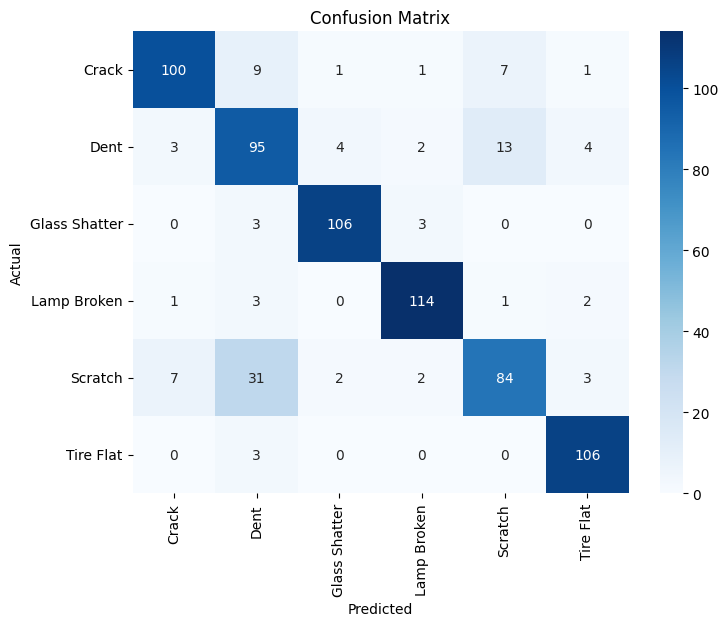

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


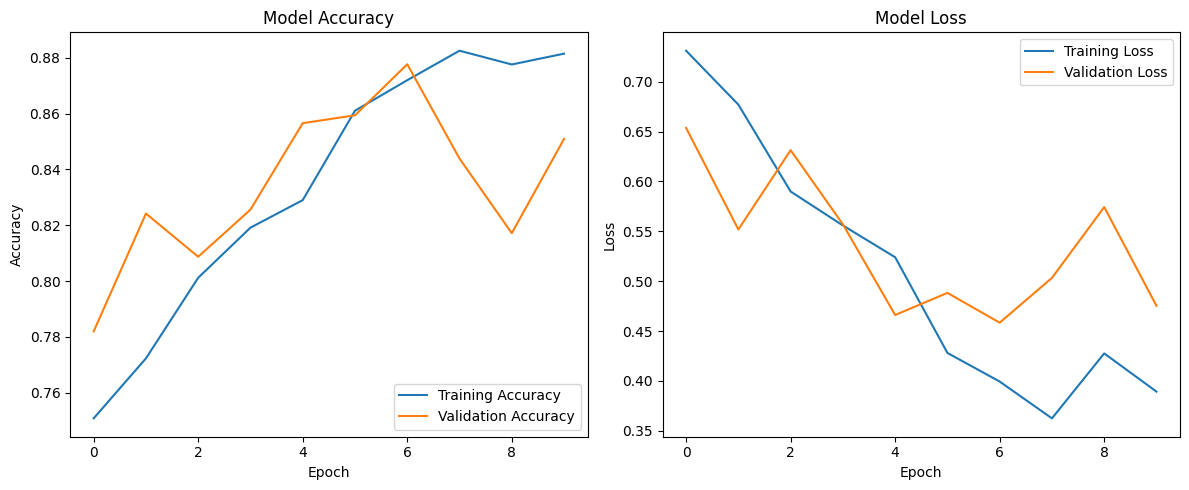

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


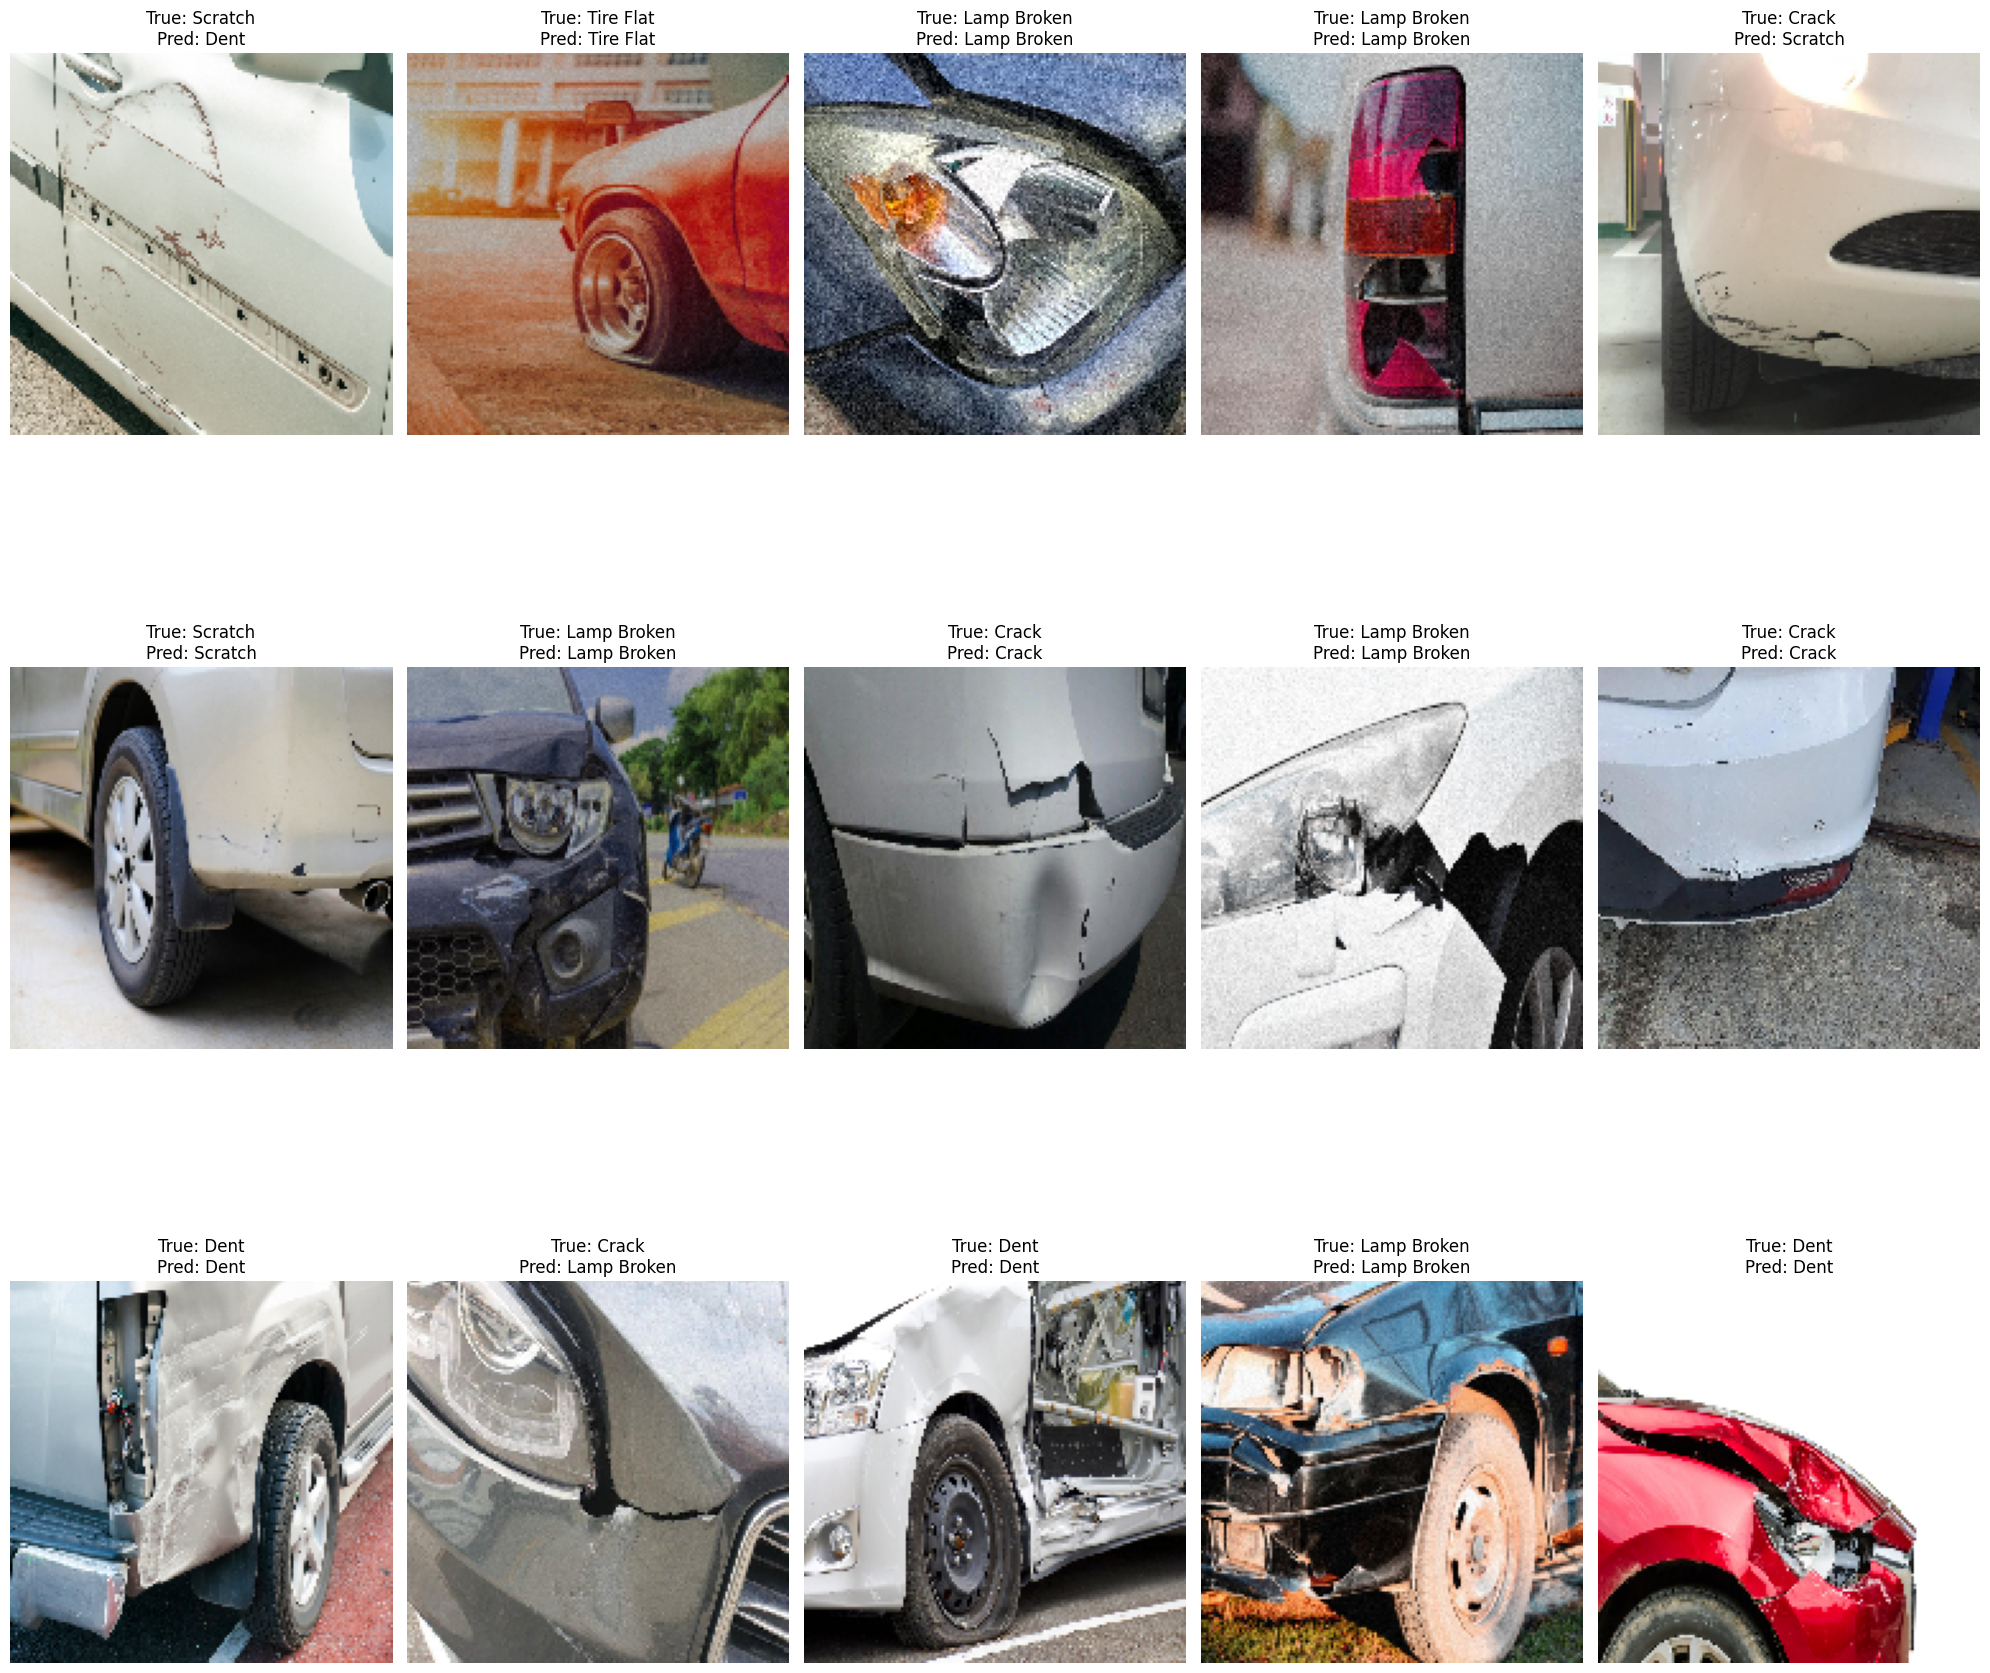

In [19]:
import random
import matplotlib.pyplot as plt

# Function to predict and visualize random images
def predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15):
    # Select random images from the base directory
    random_images = []
    for _ in range(num_images):
        random_class = random.choice(classes)
        folder_path = os.path.join(base_dir, random_class)
        random_file = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, random_file)
        random_images.append((img_path, random_class))

    # Plot the images with predictions
    plt.figure(figsize=(20, 20))
    for i, (img_path, true_class) in enumerate(random_images):
        # Load and preprocess the image
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = classes[np.argmax(prediction)]

        # Display the image with true and predicted labels
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize 15 predictions
predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15)
